In [1]:
import librosa.display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import IPython.display as ipd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import wave
from scipy.fftpack import fft
from numpy.fft import *
from tensorflow.keras.utils import to_categorical
from pathlib import Path
train_audio_path = Path(r'F:\speech recognition\greek_dataset_phylology_dept') #GREEK DATASET
# train_audio_path = Path(r'D:\speech recognition\train\audio') #ENGLISH DATASET
noise_path=Path(r'F:\speech recognition\_background_noise_') #NOISE DIRECTORY
SAMPLE_RATE=16000

Preprocessing

In [ ]:
##preprocessing and feature extraction
def create_df(path): #LOADING GREEK DATA
    tmp_list=[]
    files = [f for f in os.listdir(str(path)) if f.endswith('.wav')]
    for file in files:
        if file.endswith('.wav'):
            tmp_path=os.path.join(path, file)
            word_label= file.split('_')[-2]
            tmp_list.append([tmp_path,word_label])
        else:
            continue
    return  pd.DataFrame(tmp_list,columns=['file_path','word_label']) #dataframe containing the path for each word

def create_noisy_wav(data,sr): #FUNCTION FOR ADDING BACKGROUND NOISE
    noisy_dict={"noisy_wav":[],"sample_rate":[]}
    bg_files = os.listdir(noise_path)
    
    for bg in bg_files:
        bgdata,samplerate = librosa.load(str(noise_path)+ '//' + bg,sr=SAMPLE_RATE)
        start = np.random.randint(bgdata.shape[0]-len(data))
        bg_slice = bgdata[start : start + len(data)]
        wav_with_bg = data * np.random.uniform(0.8, 1.2) + bg_slice * np.random.uniform(0.2, 0.6)
        noisy_dict["noisy_wav"].append(wav_with_bg)
        noisy_dict["sample_rate"].append(sr)
    return noisy_dict

def stretch(data, factor): #AUGMENTATION FUNCTION FOR MODYFYING TIMESERIES LENGTH 
    input_length = len(data)
    stretched = librosa.effects.time_stretch(data, factor)
    if len(stretched)>input_length:
        stretched = stretched[:input_length]
    else:
        pos=int((input_length-len(stretched))/2)
        stretched=np.pad(stretched, pad_width=(pos, pos), mode='constant')
    return stretched

def pitch(data, sampling_rate, pitch_factor): #AUGMENTATION FUNCTION FOR MODIFYING SOUND PITCH
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def findmaxlength(audio_path,lengths): #FUNCTION WHICH FINDS THE TIMESERIES WITH THE MOST SAMPLES

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    lengths.append(len(data))
    
    return lengths

def extract_feat(data,sr): #FEATURE EXTRACTION AND STACKING TO AN ARRAY
    image_w_features = np.array([])

    mfcc = librosa.feature.mfcc(data,sr=sr,n_mfcc=13,n_fft=2048,hop_length=512).T
                    
    zcr=librosa.feature.zero_crossing_rate(data, frame_length=2048, hop_length=512, center=True).T
    
    spectral_roloff=librosa.feature.spectral_rolloff(data, sr=sr,n_fft=2048, hop_length=512,center=True).T
    
    chromagram = librosa.feature.chroma_stft(data, sr=sr, hop_length=512).T
    
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr,hop_length=512,n_fft=2048, center=True).T

    image_w_features=np.hstack((mfcc,zcr))

    image_w_features=np.hstack((image_w_features,spectral_roloff))
    image_w_features=np.hstack((image_w_features,chromagram))
    image_w_features=np.hstack((image_w_features,spec_bw))
 
    return image_w_features

def get_feat_padded(audio_path,word,megistomikos):#ZERO PADDING FOR EQUAL LENGTH TIMESERIES
    noisy_feat_list=[]
    feat_list=[]

    data,samplerate = librosa.load(audio_path,SAMPLE_RATE)
    if len(data)<megistomikos:
        poso=int((megistomikos-len(data))/2)
        data=np.pad(data, pad_width=(poso, poso), mode='constant')
               
    #ta miki

    tamikimeta.append(len(data))
    clean_feat = extract_feat(data,SAMPLE_RATE)
    clean_image_feat = np.array(clean_feat)         
    feat_list.append(clean_image_feat)

    if word not in wordlist:
        # pitch_factor = np.random.uniform(low=-4,high=4)
        # pitched=pitch(data,samplerate,pitch_factor)
        # pitched_feat = extract_feat(pitched,samplerate)
        # pitched_image_feat=np.array(pitched_feat)
        stretch_factor=np.random.uniform(low=0.8,high=1.25)
        stretched=stretch(data,stretch_factor)
        stretched_feat = extract_feat(stretched,SAMPLE_RATE)
        stretched_image_feat=np.array(stretched_feat)
        feat_list.append(stretched_image_feat)

        
        noisy_wavs= create_noisy_wav(data,SAMPLE_RATE)                

        for noisydata,sr  in zip(noisy_wavs["noisy_wav"], noisy_wavs["sample_rate"]):
             samples=np.array(noisydata)
             noisy_feat = extract_feat(samples,SAMPLE_RATE)
             noisy_image_feat= np.array(noisy_feat)
             feat_list.append(noisy_image_feat)
    return feat_list#clean_image_feat,pitched_image_feat,noisy_feat_list,stretched_image_feat

    
tamikimeta=[]
lengths=[]
X, Y, paths = [], [], []
wordlist=["και","να","το","του"] #words to be excluded from augmentation since they already have too much records

speech_dataframe=create_df(train_audio_path)
speech_dataframe = speech_dataframe.sample(frac = 1) #shuffling dataframe rows
# speech_dataframe=speech_dataframe.groupby('word_label').apply(lambda x: x.sample(1000))
for path in speech_dataframe.file_path:
    miki= findmaxlength(path,lengths)
    
maxmikos=max(miki)
print(maxmikos)

for path, word in zip(speech_dataframe.file_path, speech_dataframe.word_label):
    result=get_feat_padded(path,word,maxmikos) 
    for feat in result:
        X.append(feat)
        Y.append(word)  
        paths.append(path)  
 
tameta=np.array(tamikimeta)        
plt.hist(tameta)

Counting number of records per word

In [3]:
unique, counts = np.unique(Y, return_counts=True)
count_sort_ind = np.argsort(-counts)
print(dict(zip(unique[count_sort_ind],counts[count_sort_ind])))

{'από': 2334, 'δεν': 2313, 'και': 2031, 'που': 1941, 'να': 1824, 'ο': 1803, 'στο': 1734, 'την': 1725, 'το': 1706, 'με': 1677, 'τα': 1524, 'θα': 1422, 'σε': 1407, 'είναι': 1389, 'του': 1367, 'για': 1356, 'ένα': 1335, 'μου': 1323, 'ναι': 1320, 'τον': 1266, 'της': 1251, 'μία': 1236, 'ήταν': 936, 'αυτό': 933, 'η': 909, 'πολύ': 885, 'ότι': 843, 'τη': 816, 'εγώ': 741, 'σου': 738, 'τι': 642, 'είχε': 615, 'στον': 570, 'έχει': 567, 'αλεπού': 546, 'μέσα': 501, 'σπιτιού': 498, 'αλλά': 492, 'σπίτι': 471, 'πηγάδι': 468, 'οι': 465, 'βοριάς': 459, 'γιατί': 447, 'τώρα': 447, 'μας': 444, 'έχω': 441, 'έτσι': 435, 'ένας': 435, 'μετά': 435, 'τους': 213}


Reshaping feature array

In [4]:
ar1=np.array(X)
orig_shape = ar1.shape
arr = np.reshape(ar1, (ar1.shape[0], ar1.shape[1]*ar1.shape[2]))
print(arr.shape)

(51676, 1092)


Applying oversampling/undersampling techniques for data balancing

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline

oversampler_strategy = {  'πολύ': 900, 'ότι': 900, 'τη': 900, 'εγώ': 900, 'σου': 900,
   'τι': 900, 'είχε': 900, 'στον': 900, 'έχει': 900, 'αλεπού': 900, 'μέσα': 900, 'σπιτιού': 900, 'αλλά': 900, 'σπίτι': 900, 'πηγάδι': 900,
    'οι': 900, 'βοριάς': 900, 'γιατί': 900, 'τώρα': 900, 'μας': 900, 'έχω': 900, 'έτσι': 900, 'ένας': 900, 'μετά': 900,'τους': 900}
over = SMOTE(sampling_strategy=oversampler_strategy)
undersampler_strategy = {'από': 1000, 'δεν': 1000, 'και': 1000, 'που': 1000, 'να': 1000, 'ο': 1000, 'στο': 1000, 'την': 1000, 'το': 1000, 'με': 1000,
 'τα': 1000, 'θα': 1000, 'σε': 1000, 'είναι': 1000, 'του': 1000, 'για': 1000, 'ένα': 1000, 'μου': 1000, 'ναι': 1000, 'τον': 1000,
  'της': 1000, 'μία': 1000}
under = NearMiss(sampling_strategy=undersampler_strategy)#, version=3)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
Xnew, Ynew = pipeline.fit_resample(arr, Y)

Inspect new record distribution of balanced data

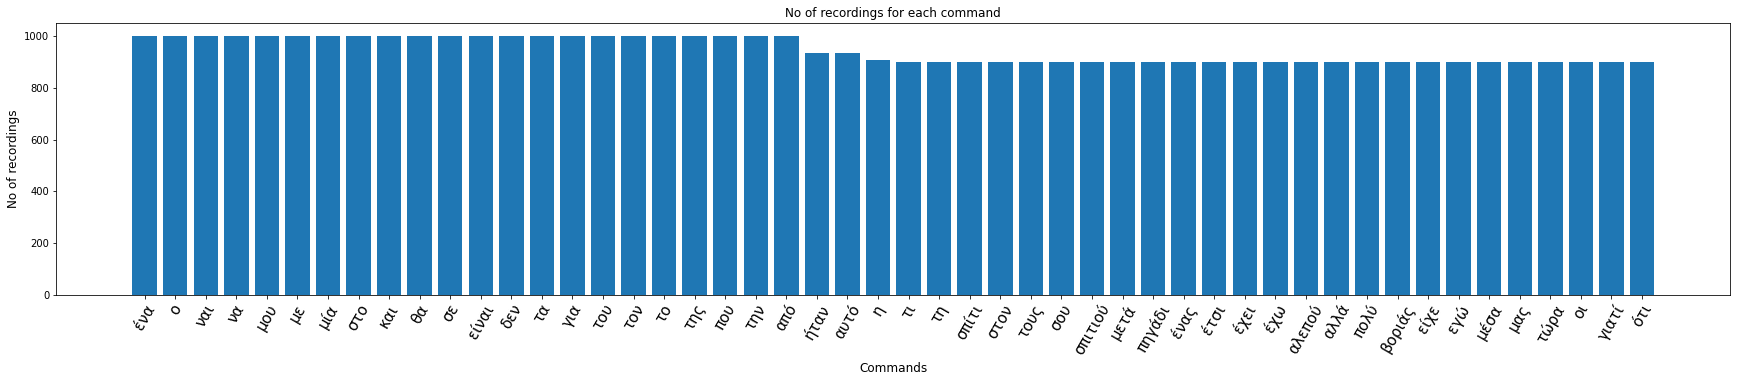

In [13]:
import matplotlib.pyplot as plt

data = dict(zip(unique[count_sort_ind],counts[count_sort_ind]))
words = list(data.keys())
values = list(data.values())

plt.figure(figsize=(30,5))
index= np.arange(len(words))
plt.bar(index, values, tick_label=words)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index,words,fontsize=15,rotation=60)
plt.title('No of recordings for each command')

plt.show()

In [10]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

Xnew=X
Ynew=Y
#scaling and encoding
scaler = StandardScaler()
#X_simple=np.array(X)
Xnew=np.array(Xnew)
Xnew = scaler.fit_transform(Xnew.reshape(-1, Xnew.shape[-1])).reshape(Xnew.shape)
print("padded and scaled features ",Xnew.shape)
#encoding the labels 
print("label ",Ynew[0])

le = LabelEncoder()
Ynew = to_categorical(le.fit_transform(Ynew)) 
print("encoded label ",Ynew[0])

padded and scaled bbbic (47278, 39, 28)
da label ένα
da encoded label [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


Train,test,validation split and CNN model training

In [12]:
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
keras.backend.clear_session()

#creating test and validation set
X_train, X_test, Y_train, Y_test = train_test_split(Xnew,Ynew,test_size=0.1)
X_validation,X_test, Y_validation,Y_test = train_test_split(X_test,Y_test,test_size=0.5)


#3D->4D array for input of CNN
X_train=X_train[..., np.newaxis]
X_validation=X_validation[..., np.newaxis]
X_test=X_test[..., np.newaxis]

#building model
input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)
cnnModel=keras.Sequential()


cnnModel.add(keras.layers.Conv2D(64,(3,3),activation='relu',input_shape=input_shape))#32
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())

cnnModel.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape))
cnnModel.add(keras.layers.MaxPooling2D((3,3), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
cnnModel.add(keras.layers.Conv2D(32,(2,2),activation='relu',input_shape=input_shape))#22
cnnModel.add(keras.layers.MaxPooling2D((2,2), strides=(2,2),padding='same'))
cnnModel.add(keras.layers.BatchNormalization())
            
             
#flatten the output and dense layers
cnnModel.add(keras.layers.Flatten())
cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
cnnModel.add(keras.layers.Dropout(0.3))
#cnnModel.add(keras.layers.Dense(64,activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
#cnnModel.add(keras.layers.Dropout(0.3))
             
#ouput layer
cnnModel.add(keras.layers.Dense(50,activation='softmax'))
             
optimiz = keras.optimizers.Adam(0.0001)
cnnModel.compile(optimizer=optimiz,loss="categorical_crossentropy",metrics=["accuracy"])             
cnnModel.summary()         

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, verbose=1, mode='min', restore_best_weights=True)

historyConv=cnnModel.fit(X_train,Y_train,validation_data=(X_validation,Y_validation),callbacks=[monitor],batch_size=32,epochs=200)

test_error,test_accuracy=cnnModel.evaluate(X_test,Y_test,verbose=1)  
print("Accuracy on test set is {}".format(test_accuracy))            
print("Error on test set is {}".format(test_error))                  

(39, 28, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 37, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 13, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 19, 13, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 11, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 6, 32)         0         
 2D)                                                             
                                            

74/74 [==============================] - 0s 6ms/step - loss: 1.1387 - accuracy: 0.6870
Test accuracy: 68.6971%
Test error: 1.1387%


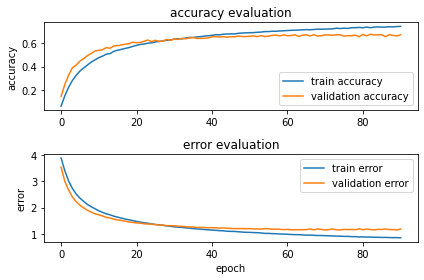

In [13]:
##accuracy and error diagrams 
score = cnnModel.evaluate(X_test,Y_test,verbose=1)
accuracy = 100*score[1]

print("Test accuracy: %.4f%%" % accuracy) 
print("Test error: %.4f%%" % test_error) 

fig,axs= plt.subplots(2)

axs[0].plot(historyConv.history["accuracy"], label="train accuracy")
axs[0].plot(historyConv.history["val_accuracy"], label="validation accuracy")
axs[0].set_ylabel("accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("accuracy evaluation")


axs[1].plot(historyConv.history["loss"], label="train error")
axs[1].plot(historyConv.history["val_loss"], label="validation error")
axs[1].set_ylabel("error")
axs[1].set_xlabel("epoch")
axs[1].legend(loc="upper right")
axs[1].set_title("error evaluation")

plt.tight_layout()
plt.show()

Evaluating model accuracy for each command through confusion matrix and classification report

74/74 [==============================] - 0s 4ms/step


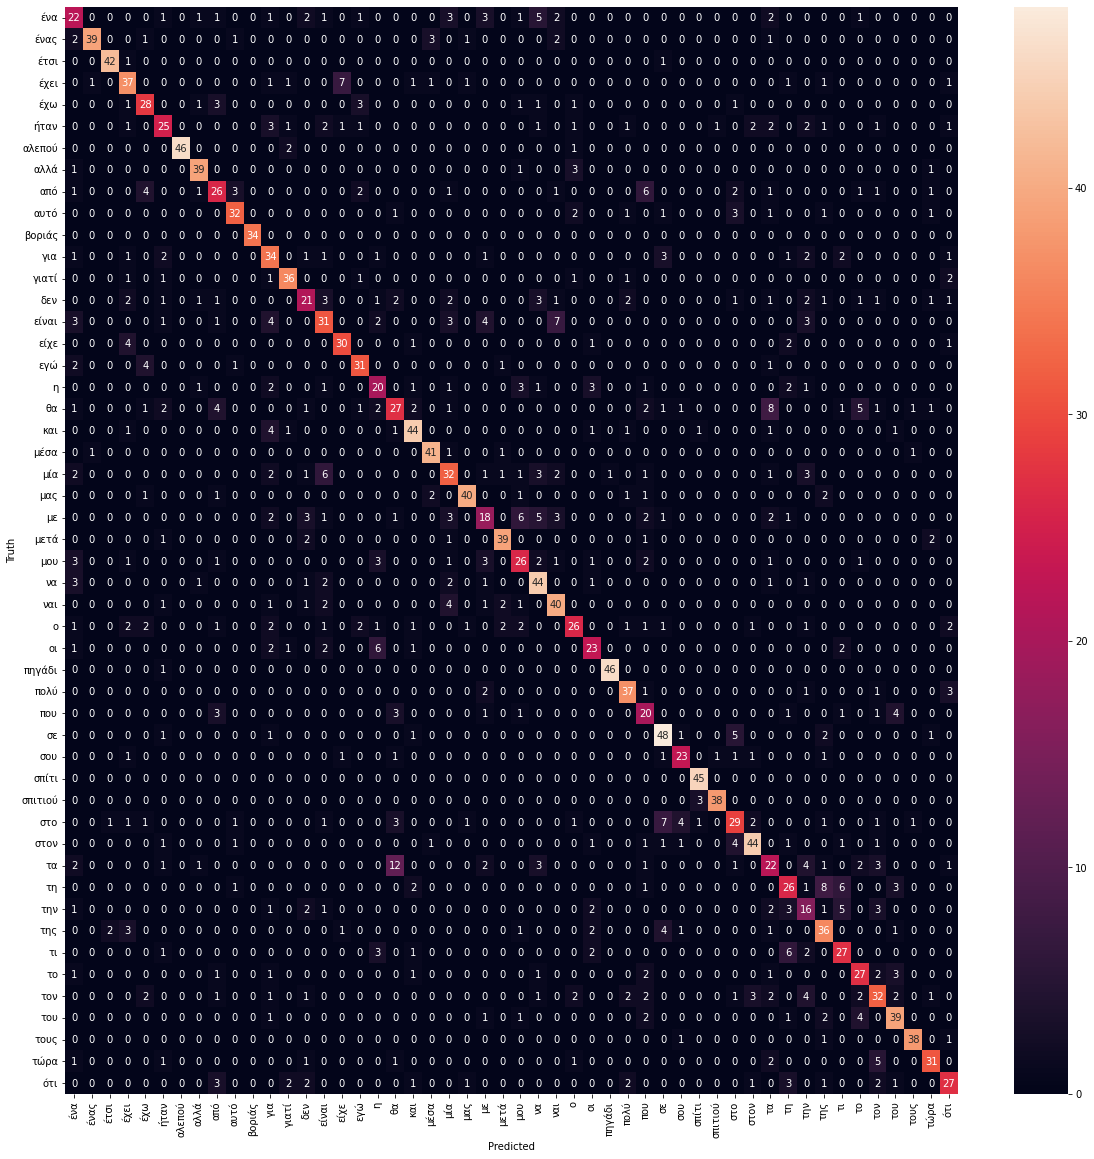

In [23]:
##confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
prediction= cnnModel.predict(X_test)
y_class1=prediction.argmax(axis=-1)

y_class2=Y_test.argmax(axis=1)
#print(y_class1)
#print(y_class2)
confMat=confusion_matrix(y_class2,y_class1)

namelist=le.classes_
newdf=pd.DataFrame(confMat,index =[i for i in namelist],columns = [i for i in namelist])
plt.figure(figsize = (20,20))
splot = sn.heatmap(newdf, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
sfig = splot.get_figure()
#sfig.savefig('confMatrix.png')

In [22]:
from sklearn.metrics import classification_report
prediction= cnnModel.predict(X_test)
print(classification_report(np.argmax(Y_test, axis=1), np.argmax(prediction, axis=1), target_names=le.classes_))

74/74 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

         ένα       0.46      0.47      0.46        47
        ένας       0.95      0.78      0.86        50
        έτσι       0.93      0.95      0.94        44
        έχει       0.65      0.70      0.67        53
         έχω       0.64      0.70      0.67        40
        ήταν       0.61      0.53      0.57        47
      αλεπού       1.00      0.94      0.97        49
        αλλά       0.85      0.87      0.86        45
         από       0.55      0.51      0.53        51
        αυτό       0.80      0.74      0.77        43
      βοριάς       1.00      1.00      1.00        34
         για       0.53      0.67      0.59        51
       γιατί       0.82      0.82      0.82        44
         δεν       0.54      0.43      0.48        49
       είναι       0.56      0.53      0.54        59
        είχε       0.75      0.77      0.76        39
         εγώ       0.74     